<a href="https://colab.research.google.com/github/crismunoz/Fuzzy-Logic/blob/master/6_RulesExtraction/Fuzzy_Rules_(Dolar).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Cristian Muñoz Villalobos

In [ ]:
!wget https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/Dolar.txt
!wget https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/fuzzy_rules.py
!pip install scikit-fuzzy

In [47]:
from datetime import timedelta, date
from operator import itemgetter
from itertools import groupby

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pprint
import os

import skfuzzy as fuzz
from skfuzzy import control as ctrl
from fuzzy_rules import extract_rules,config_input_variable,config_output_variable,define_input_variables,define_output_variables,read_dataset

from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split

# Read data with format (tab separator): 

In [48]:
cat Dolar.txt | head -5 

2,34
2,331
2,291
2,288
2,282


Text(0, 0.5, 'value')

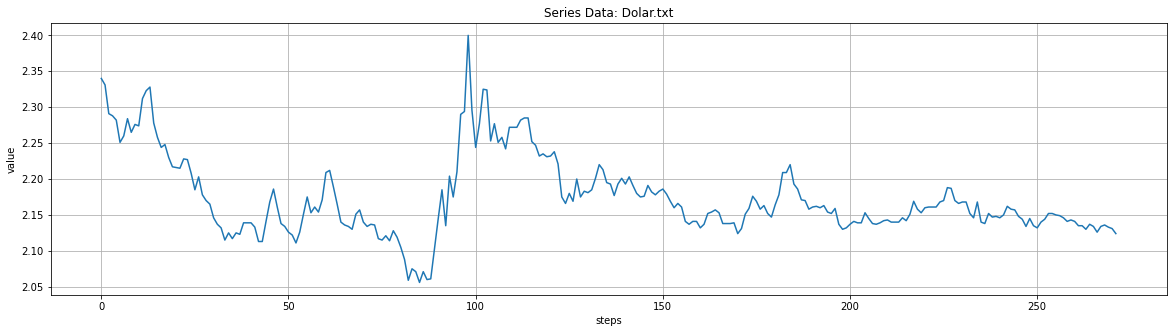

In [49]:
file_path='Dolar.txt'
data = read_dataset(file_path)
plt.figure(figsize=(20,5))
plt.title('Series Data: {}'.format(file_path))
plt.plot(data)
plt.grid()
plt.xlabel('steps')
plt.ylabel('value')

# Preprocessing Data

In [67]:
steps_forward=1
windows_size=7
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.window(windows_size + steps_forward, shift=1, drop_remainder=True)
dataset = np.stack([list(window_dataset) for window_dataset in dataset], axis=0)
X,y_true = dataset[:,:-steps_forward,0],dataset[:,-steps_forward:][:,-1,:]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.20, shuffle=False)

print('-'*21+'\nDataset Distribution\n'+'-'*21)
print('X\t:{} | y_true\t:{}'.format(X.shape,y_true.shape))
print('X_train\t:{} | y_train\t:{}'.format(X_train.shape,y_train.shape))
print('X_test\t:{}  | y_test\t:{}'.format(X_test.shape,y_test.shape))

---------------------
Dataset Distribution
---------------------
X	:(265, 7) | y_true	:(265, 1)
X_train	:(212, 7) | y_train	:(212, 1)
X_test	:(53, 7)  | y_test	:(53, 1)


# Configuration

## Variable Parameters
- nb_inputs: Number of input variable
- nb_outputs: Number of output variables
- nb_sets: Number of fuzzy set by variable
- min : list of min value for each variables
- max : list of max value for each variables
- shoulder : The first and last set are trapezoidal function

## Fuzzy System Parameters
- defuzzify_method: Controls which defuzzification method will be used. 
    - 'centroid': Centroid of area 
    - 'bisector': bisector of area 
    - 'mom' : mean of maximum 
    - 'som' : min of maximum 
    - 'lom' : max of maximum
- aggregation_opt: mathematic function for OR and AND operation

## Fuzzy Rules Parameters
- intersection_op: operator to calculate Dr value for each candidate rule

## Other Parameters (optional)
- resolution: number of points in discret domain for each I/O variable.
- epsilon: gap for min value (min - epsilon) and max value (max + epsilon)

In [68]:
x_min_value = X.min(axis=0)
x_max_value = X.max(axis=0)
y_min_value = y_true.min(axis=0)
y_max_value = y_true.max(axis=0)

aggregation_opt={
'and_func':np.fmin,
'or_func': np.fmax
}

config = {
    
# Variable Parameters
'nb_inputs':X_train.shape[-1],
'nb_outputs':y_train.shape[-1],
'nb_sets':7,
'min':[x_min_value,y_min_value],
'max':[x_max_value,y_max_value],
'shoulder':True,

# Fuzzy System Parameters
'defuzzify_method':'centroid',
'aggregation_opt': aggregation_opt,

# Fuzzy Rules Parameters
'intersection_op': np.prod,

#Other Parametres
'resolution':1000,
'epsilon':0.001
}

pp = pprint.PrettyPrinter(depth=6)
pp.pprint(config)
pp.pprint(aggregation_opt)

{'aggregation_opt': {'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>},
 'defuzzify_method': 'centroid',
 'epsilon': 0.001,
 'intersection_op': <function prod at 0x7f8f188f5048>,
 'max': [array([2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]), array([2.4])],
 'min': [array([2.056, 2.056, 2.056, 2.056, 2.056, 2.056, 2.056]),
         array([2.056])],
 'nb_inputs': 7,
 'nb_outputs': 1,
 'nb_sets': 7,
 'resolution': 1000,
 'shoulder': True}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}


In [69]:
antecedents = define_input_variables(config, shoulder=config['shoulder'])
consequents = define_output_variables(config, shoulder=config['shoulder'], defuzzify_method=config['defuzzify_method'])
print(antecedents)
print(consequents)

[Antecedent: I_1, Antecedent: I_2, Antecedent: I_3, Antecedent: I_4, Antecedent: I_5, Antecedent: I_6, Antecedent: I_7]
[Consequent: O_1]


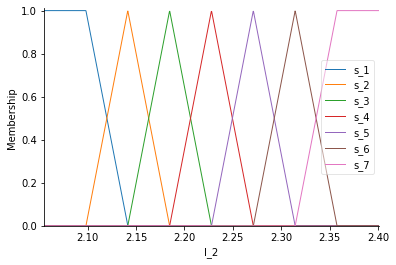

In [70]:
antecedents[1].view()

In [71]:
rules,df_rules = extract_rules(config, antecedents, consequents, X_train, y_train)
print('number of rules:', len(df_rules))

number of rules: 129


In [72]:
df_rules.head(10)

,I_1,I_2,I_3,I_4,I_5,I_6,I_7,O_1,Dr
0,s_1,s_1,s_1,s_1,s_1,s_1,s_1,s_1,1.000000
1,s_1,s_1,s_1,s_1,s_1,s_1,s_2,s_3,0.813407
2,s_1,s_1,s_1,s_1,s_1,s_2,s_3,s_2,0.691161
3,s_1,s_1,s_1,s_1,s_2,s_3,s_2,s_3,0.383534
4,s_1,s_1,s_1,s_2,s_3,s_2,s_3,s_3,0.297073
5,s_1,s_1,s_2,s_1,s_2,s_1,s_1,s_1,0.035058
6,s_1,s_1,s_2,s_3,s_2,s_3,s_3,s_4,0.173436
7,s_1,s_1,s_2,s_3,s_3,s_2,s_2,s_2,0.106539
8,s_1,s_2,s_1,s_1,s_1,s_1,s_1,s_1,0.192022
9,s_1,s_2,s_1,s_2,s_1,s_1,s_1,s_1,0.061888


In [73]:
%time system = ctrl.ControlSystem(rules)

CPU times: user 16.6 s, sys: 6.82 ms, total: 16.6 s
Wall time: 16.6 s


In [74]:
%time sim = ctrl.ControlSystemSimulation(system)

CPU times: user 193 µs, sys: 2 µs, total: 195 µs
Wall time: 217 µs


In [75]:
import numpy as np

def evaluate_model(sim, x_data, y_data, return_results=False):
  y_prev = []
  for x in x_data:
      for i,x_i in enumerate(x,1):
          sim.input['I_{}'.format(i)]=x_i
      sim.compute()
      result = sim.output['O_1']
      y_prev.append(result)
      
  mse = mean_squared_error(y_data, y_prev)
  
  print('mean_squared_error: {}'.format(mse))

  plt.figure(figsize=(15,5))
  plt.plot(y_data,'*')
  plt.plot(y_prev,'s')
  plt.show()

  y_data, y_prev = np.squeeze(np.array(y_data)), np.array(y_prev)
  table_results = pd.DataFrame()
  table_results['Real']=y_data
  table_results['Predicted']=y_prev
  table_results['Diference']=np.abs(y_data - y_prev) 
  table_results['Diference (%)']=np.abs((y_data - y_prev) / y_data)
  if return_results:
    return table_results

mean_squared_error: 0.00023304112566983087


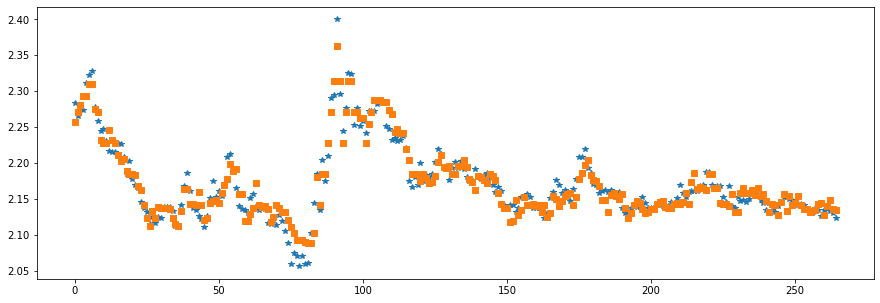

In [76]:
results=evaluate_model(sim, X, y_true, return_results=True)

In [77]:
results.head()

,Real,Predicted,Diference,Diference (%)
0,2.284,2.256443,0.027557,0.012065
1,2.265,2.271250,0.006250,0.002759
2,2.276,2.280328,0.004328,0.001902
3,2.274,2.293976,0.019976,0.008784
4,2.312,2.293976,0.018024,0.007796


mean_squared_error: 0.0002569468758431055


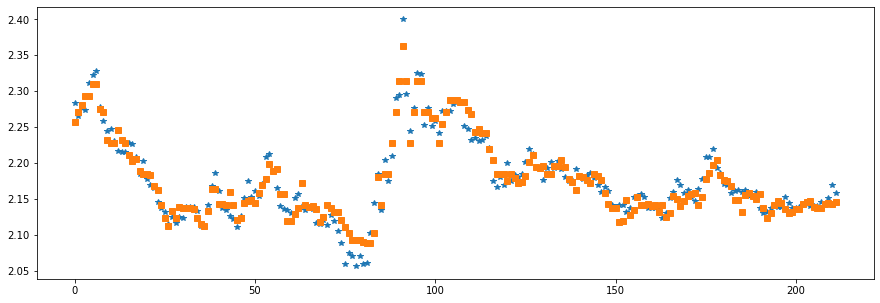

In [78]:
evaluate_model(sim, X_train, y_train)

mean_squared_error: 0.00013741812497673265


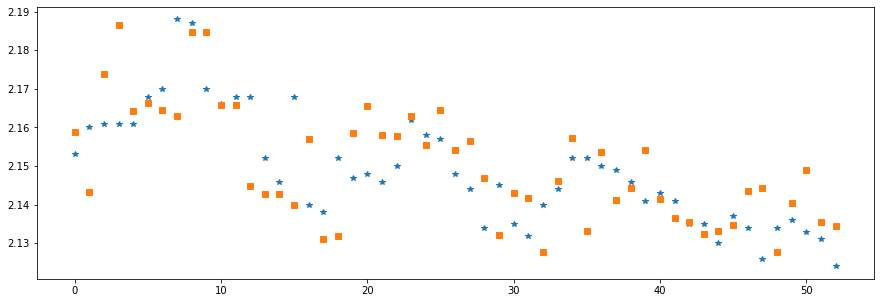

In [79]:
evaluate_model(sim, X_test, y_test)